In [1]:
import pandas as pd
import numpy as np

# The path to the file containing the deprivation and litter data.
data_fpath = "../data/glasgow-litter-simd2020v2.csv"

def remove_features(df):
  """Remove features from the data that we do not need"""
  columns_to_remove = [
    #"Total_population",
    #"Working_Age_population",
    "SIMD2020v2_Rank",
    "SIMD_2020v2_Percentile",
    "SIMD2020v2_Vigintile",
    "SIMD2020v2_Decile",
    "SIMD2020v2_Quintile",
    "SIMD2020v2_Income_Domain_Rank",
    "SIMD2020_Employment_Domain_Rank",
    "SIMD2020_Health_Domain_Rank",
    "SIMD2020_Education_Domain_Rank",
    "SIMD2020_Access_Domain_Rank",
    "SIMD2020_Crime_Domain_Rank",
    "SIMD2020_Housing_Domain_Rank"
  ]
  return df.drop(columns_to_remove, axis=1)

def impute_missing_data(df):
  """Replace missing values with their mean"""
  features = [
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "not_participating",
    "University",
    "crime_count",
    "crime_rate",
    "broadband"
  ]
  for f in features:
    df[f].fillna(df[f].mean(), inplace=True)
  return df

def convert_float_feature_types(df):
  """Convert percentage strings to floats between 0-1"""
  to_float_features = [
    "income_rate",
    "employment_rate",
    "crime_rate",
    "DEPRESS",
    "LBWT",
    "Attendance",
    "not_participating",
    "University",
    "overcrowded_rate",
    "nocentralheating_rate",
    "broadband",
    "crime_count",
    "Attainment",
  ]
  for f in to_float_features:
    df[f] = df[f].str.rstrip("%").astype(float) / 100
  return df

def convert_categorical_feature_types(df):
  """Convert strings to categorical features"""
  to_category_features = [
    "Data_Zone",
    "Intermediate_Zone",
    "Council_area"
  ]
  for f in to_category_features:
    df[f] = df[f].astype("category")
  return df

def convert_feature_types(df):
  """Convert features to the correct types"""
  df = df.replace("*", np.NaN)
  df = convert_float_feature_types(df)
  return convert_categorical_feature_types(df)

def read_data_from_file(fpath):
  """Read the data from file, handle missing data and assign feature types"""
  df = pd.read_csv(fpath, header=0)
  df = remove_features(df)
  df = convert_feature_types(df)
  df = impute_missing_data(df)
  return df

def split_data(df, valid_frac=0.2, test_frac=0.1):
  """Split into train/valid/test data (default 70%/20%/10%)"""
  train_frac = 1 - valid_frac - test_frac
  return np.split(
    df.sample(frac=1, random_state=1),
    [int(train_frac * len(df)), int((train_frac + valid_frac) * len(df))],
  )

def get_split_data():
  """Get a dataframe of the data split into train/valid/test (70%/20%/10%)"""
  df = read_data_from_file(data_fpath)
  return split_data(df)

In [2]:
df_train, df_valid, df_test = get_split_data()

print("Training data: {} observations".format(len(df_train)))
print("Validation data: {} observations".format(len(df_valid)))
print("Test data: {} observations".format(len(df_test)))

Training data: 522 observations
Validation data: 149 observations
Test data: 75 observations


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 736 to 230
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Data_Zone               522 non-null    category
 1   Intermediate_Zone       522 non-null    category
 2   Council_area            522 non-null    category
 3   Total_population        522 non-null    int64   
 4   Working_Age_population  522 non-null    int64   
 5   income_rate             522 non-null    float64 
 6   income_count            522 non-null    int64   
 7   employment_rate         522 non-null    float64 
 8   employment_count        522 non-null    int64   
 9   CIF                     522 non-null    float64 
 10  ALCOHOL                 522 non-null    float64 
 11  DRUG                    522 non-null    float64 
 12  SMR                     522 non-null    float64 
 13  DEPRESS                 522 non-null    float64 
 14  LBWT                    

In [4]:
df_train.isnull().sum()

Data_Zone                 0
Intermediate_Zone         0
Council_area              0
Total_population          0
Working_Age_population    0
income_rate               0
income_count              0
employment_rate           0
employment_count          0
CIF                       0
ALCOHOL                   0
DRUG                      0
SMR                       0
DEPRESS                   0
LBWT                      0
EMERG                     0
Attendance                0
Attainment                0
no_qualifications         0
not_participating         0
University                0
crime_count               0
crime_rate                0
overcrowded_count         0
nocentralheating_count    0
overcrowded_rate          0
nocentralheating_rate     0
drive_petrol              0
drive_GP                  0
drive_post                0
drive_primary             0
drive_retail              0
drive_secondary           0
PT_GP                     0
PT_post                   0
PT_retail           

In [5]:
df_train.describe()

,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,ALCOHOL,DRUG,SMR,...,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,litter
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.00000,...,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,824.716475,579.860153,0.200192,159.840996,0.143678,77.526820,153.271157,175.352913,159.494423,123.39572,...,2.340708,2.328983,2.616618,3.498209,4.246300,7.024756,7.025690,9.525469,0.014819,61.289272
std,241.868328,223.058864,0.122604,100.905286,0.091401,50.243402,72.005089,133.455086,169.152308,59.63204,...,1.072766,0.822855,0.888097,1.333597,1.367777,3.180411,2.505275,3.464465,0.047804,28.532681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,6.000000,0.000000,8.00000,...,0.664751,0.667906,0.982214,0.843476,1.290801,1.595565,1.831674,2.289857,0.000000,9.000000
25%,675.000000,442.750000,0.090000,70.000000,0.060000,33.000000,95.000000,77.250000,41.000000,88.00000,...,1.564193,1.735556,1.982643,2.603287,3.243758,4.777291,5.281497,6.928714,0.000000,41.000000
50%,799.500000,550.000000,0.200000,149.000000,0.140000,70.500000,157.500000,146.500000,118.500000,115.50000,...,2.080799,2.209441,2.472660,3.349401,4.124270,6.520620,6.768968,9.081822,0.000000,57.000000
75%,931.000000,657.750000,0.290000,235.750000,0.210000,112.000000,205.000000,239.000000,227.750000,146.00000,...,2.952490,2.838632,3.062354,4.350313,5.074853,8.737311,8.410446,11.762133,0.000000,77.000000
max,2544.000000,2361.000000,0.590000,546.000000,0.470000,311.000000,370.000000,917.000000,1575.000000,824.00000,...,6.904760,5.201232,6.935962,8.521768,8.467000,21.908923,16.288734,23.645457,0.490000,179.000000


In [6]:
df_train.head()

,Data_Zone,Intermediate_Zone,Council_area,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,...,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,litter
736,S01010494,Drumchapel North,Glasgow City,597,402,0.26,155,0.15,62,175.0,...,3.222870,0.917627,1.396648,3.905681,3.614526,6.852444,3.146513,8.080422,0.00,78
175,S01009933,Pollokshaws,Glasgow City,932,690,0.29,266,0.22,152,175.0,...,1.278688,1.994406,2.279222,3.114805,4.655545,5.501298,7.250561,9.325655,0.01,115
242,S01010000,Kingspark North,Glasgow City,582,406,0.09,54,0.08,32,105.0,...,1.772297,1.380061,2.643185,3.608989,4.624742,6.238364,4.524683,7.482029,0.00,76
311,S01010069,Shettleston South,Glasgow City,845,605,0.09,79,0.08,50,130.0,...,1.859217,2.157485,3.673394,1.920390,4.697597,6.666661,5.964262,7.085393,0.00,27
676,S01010434,Scotstoun South and West,Glasgow City,620,453,0.40,249,0.26,117,210.0,...,1.404651,0.742263,2.396851,2.093684,4.028681,3.781043,2.340144,8.781986,0.00,171


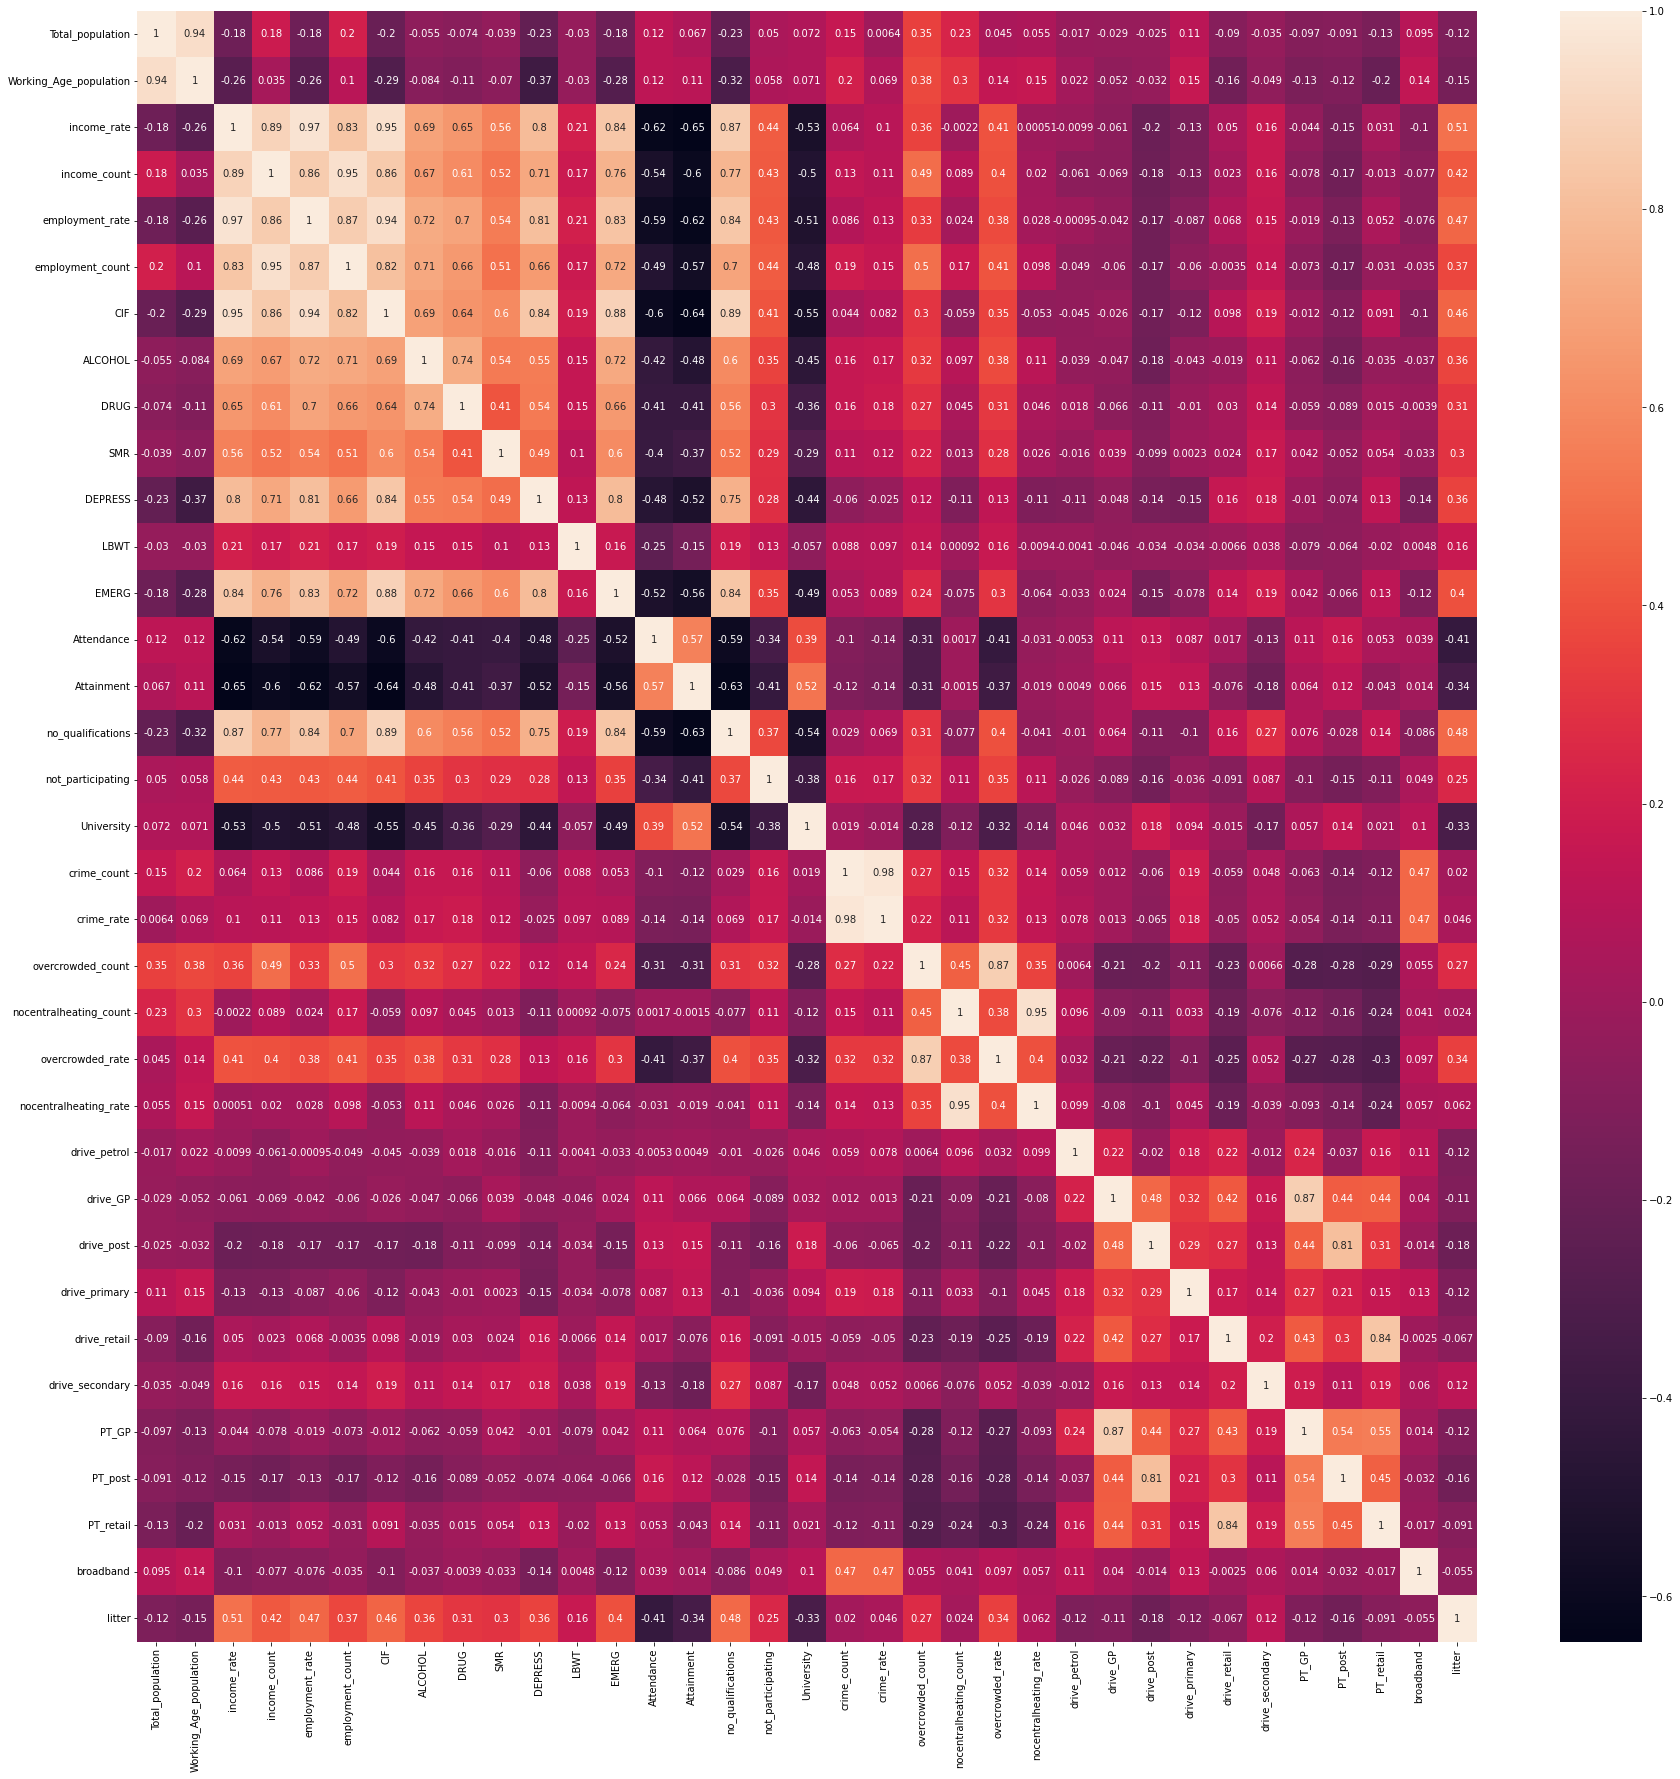

In [7]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, columns, figsize=(10,10)):
  plt.figure(figsize=figsize)
  corr_df = pd.DataFrame(df, columns=columns)
  sn.heatmap(corr_df.corr(), annot=True)
  plt.show()

plot_correlation_matrix(df_train, df_train.columns, figsize=(30,30))

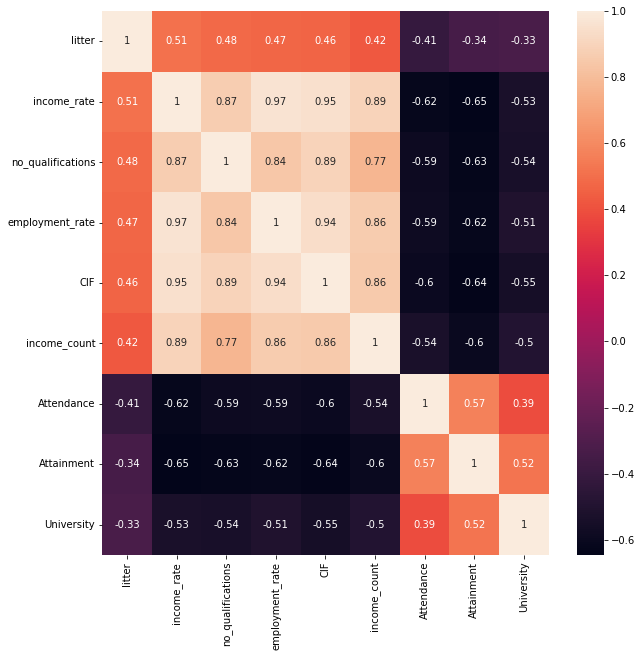

In [8]:
plot_correlation_matrix(df_train, columns=[
  "litter",
  "income_rate",
  "no_qualifications",
  "employment_rate", 
  "CIF",
  "income_count", 
  "Attendance",
  "Attainment",
  "University"
])

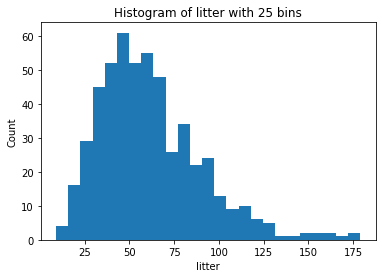

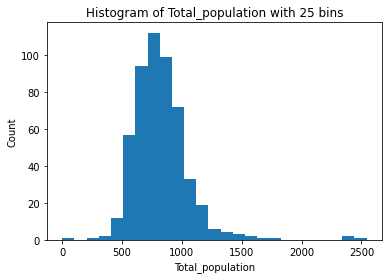

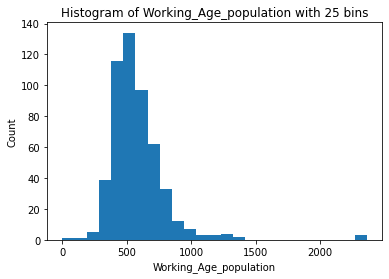

In [9]:
def plot_histogram(column, bins=25):
  ax = df_train.hist(column=column, bins=bins, grid=False)
  for x in ax[0]:
    x.set_title(f"Histogram of {column} with {bins} bins")
    x.set_xlabel(column)
    x.set_ylabel("Count")

plot_histogram("litter")
plot_histogram("Total_population")
plot_histogram("Working_Age_population")

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

def forward_selection(df, response, smf_model=smf.poisson, family=sm.families.Poisson()):
    remaining = set(df.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = smf_model(formula, df).fit(method="newton")
            score = model.aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        print(f"current_score ({current_score}) > best_new_score ({best_new_score})")
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("Best new score:", best_new_score)
            print("Selected:", selected)
            print("Remaining:", remaining)
            print()
    print("Best score:", best_new_score)
    print("Selected:", selected)
    print("Remaining:", remaining)
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    print("CHOSEN FORMULA: ", formula)
    y_train, X_train = dmatrices(formula, df, return_type="dataframe")
    model = sm.GLM(y_train, X_train, family=family).fit()
    return model

df_train_in = df_train.drop(["Data_Zone", "Intermediate_Zone", "Council_area"], axis=1)
poisson_model = forward_selection(df_train_in, "litter")

Optimization terminated successfully.
         Current function value: 9.095970
         Iterations 4
Optimization terminated successfully.
         Current function value: 8.161482
         Iterations 5
Optimization terminated successfully.
         Current function value: 9.157917
         Iterations 4
Optimization terminated successfully.
         Current function value: 8.398114
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.432883
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.018142
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.948739
         Iterations 4
Optimization terminated successfully.
         Current function value: 8.625724
         Iterations 5
Optimization terminated successfully.
         Current function value: 9.027474
         Iterations 7
Optimization terminated successfully.
         Current function value: 8.344695
  

In [18]:
print(poisson_model.summary())
print("AIC:", poisson_model.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      487
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3557.5
Date:                Sun, 06 Feb 2022   Deviance:                       4061.1
Time:                        16:00:33   Pearson chi2:                 4.15e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9912
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

In [19]:
from scipy.stats import chi2

def check_pearson_chi2(pearson_chi2, residuals):
  chi_sq = chi2.ppf(.05, df=residuals)
  print("Pearson Chi Sq <= Chi Sq")
  print(f"{pearson_chi2} <= {chi_sq}")
  print(f"The model fits: {pearson_chi2 <= chi_sq}")

check_pearson_chi2(pearson_chi2=poisson_model.pearson_chi2, residuals=poisson_model.df_resid)

Pearson Chi Sq <= Chi Sq
4146.735328641392 <= 436.8277248310166
The model fits: False


In [24]:
nb_model = forward_selection(df_train_in, "litter", smf_model=smf.negativebinomial, family=sm.families.NegativeBinomial(alpha=1))

Optimization terminated successfully.
         Current function value: 4.666632
         Iterations 4
Optimization terminated successfully.
         Current function value: 4.575921
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.671775
         Iterations 4
Optimization terminated successfully.
         Current function value: 4.603803
         Iterations 4
Optimization terminated successfully.
         Current function value: 4.599631
         Iterations 4
Optimization terminated successfully.
         Current function value: 4.562802
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.654346
         Iterations 4
Optimization terminated successfully.
         Current function value: 4.617599
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.661879
         Iterations 4
Optimization terminated successfully.
         Current function value: 4.601425
  

In [25]:
print(nb_model.summary())
print("AIC:", nb_model.aic)
check_pearson_chi2(pearson_chi2=nb_model.pearson_chi2, residuals=nb_model.df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      520
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2674.5
Date:                Sun, 06 Feb 2022   Deviance:                       108.97
Time:                        16:02:40   Pearson chi2:                     111.
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0001229
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.1075      0.051     80.229      

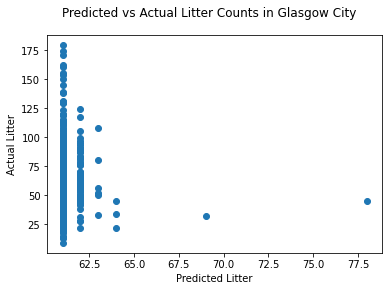

In [26]:
import matplotlib.pyplot as plt

def get_predicted_counts(model, X):
    predictions = model.get_prediction(X)
    df_predictions = predictions.summary_frame()
    return round(df_predictions["mean"])

def scatter_plot(df, formula, model):
    y, X = dmatrices(formula, df, return_type="dataframe")
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    fig = plt.figure()
    fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
    plt.scatter(x=predicted_counts, y=actual_counts)
    plt.xlabel("Predicted Litter")
    plt.ylabel("Actual Litter")
    plt.show()

scatter_plot(df_train_in, "litter ~ crime_count", nb_model)

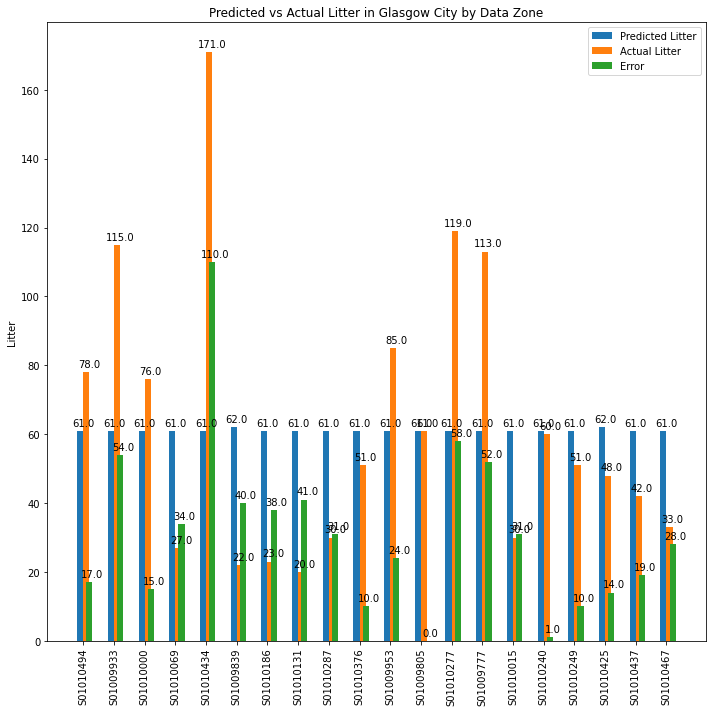

In [27]:
def bar_plot(df, formula, model, n_bars=20, bar_width=0.2):
    y, X = dmatrices(formula, df, return_type="dataframe")
    indices = X.index[:n_bars]
    labels = read_data_from_file(data_fpath).iloc[indices]["Data_Zone"]
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    y_predicted = predicted_counts[:n_bars]
    y_actual = actual_counts[:n_bars]
    y_err = abs(y_predicted - y_actual)

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    x = np.arange(len(labels))
    rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter")
    rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter")
    rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error")
    ax.set_ylabel("Litter")
    ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()
    for rects in [rects1, rects2, rects3]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height}",
                xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va='bottom'
        )
    fig.tight_layout()
    plt.show()

bar_plot(df_train_in, "litter ~ crime_count", nb_model)